In [1]:
#
!pip install --upgrade scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 13.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


In [2]:
#
!pip install infomap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.8/264.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for infomap: filename=infomap-2.8.0-cp310-cp310-linux_x86_64.whl size=7695887 sha256=20d43b04d39de0843b4a5fbbf4a1b895eb18b274da1f435709aeb738804e050e
  Stored in directory: /root/.cache/pip/wheels/b5/0c/9b/9816a0207b931219a0c5b2edc14d84099ddd57f7097f926b16
Successfully built infomap


## Librairies

In [3]:
import numpy as np
import pandas as pd
import json
import scipy
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
import time
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community.quality import modularity
from infomap import Infomap
from networkx.algorithms.link_prediction import jaccard_coefficient
from networkx.algorithms.link_prediction import adamic_adar_index
from networkx.algorithms.community.quality import modularity
#from networkx.algorithms.link_prediction import common_neighbors

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation

In [5]:
df = pd.read_csv('/content/drive/MyDrive/data.csv', sep=',(?=\S)', engine='python')


df['friends'] = [json.loads(x) for x in df['friends']]
df['id'] = [int(str(x).replace('"', '')) for x in df['id']]
df['screenName'] = [x.replace('"', '') for x in df['screenName']]

df = df[df['friendsCount'] < 300]
print("nombre de data : " + str(len(df)))

nombre de data : 13164


# Communities Detection

## Louvain Algorithm

In [6]:
from community import community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import random

In [7]:
G = nx.Graph()
for index, row in df.iterrows():
    G.add_node(row['id'], screenName=row['screenName'])
    for friend in row['friends']:
        G.add_edge(row['id'], friend)

In [8]:
# Limiter le nombre de nœuds
def limit_graph_size(G, max_nodes=10):
    # Sélectionner un sous-ensemble aléatoire de nœuds
    nodes = random.sample(G.nodes(), max_nodes)
    # Créer un sous-graphe avec ces nœuds
    subgraph = G.subgraph(nodes)
    return subgraph

# Limiter le graphe à un nombre maximum de nœuds
limite = 10000
print("limite : " + str(limite))
G_limited = limit_graph_size(G, max_nodes=limite)

limite : 10000


<ipython-input-8-6d4bd1059a94>:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  nodes = random.sample(G.nodes(), max_nodes)


limite : 10000


<ipython-input-9-46533394f349>:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  nodes = random.sample(G.nodes(), max_nodes)


Modularité de l'algorithme de Louvain : 0.9329
Nombre de communautés détectées : 9900
Temps d'exécution : 3.1073 secondes


<ipython-input-9-46533394f349>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', num_communities)
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


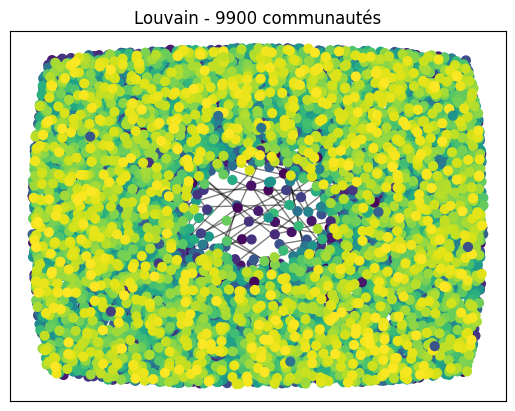

In [ ]:


# Limiter les itérations avec une version simplifiée de l'algorithme
def limited_louvain(G, max_iter=10):
    partition = community_louvain.best_partition(G, resolution=1.0)
    # Limiter les itérations
    for _ in range(max_iter):
        new_partition = community_louvain.best_partition(G, resolution=1.0)
        if new_partition == partition:
            break
        partition = new_partition
    return partition

# Calculer les partitions avec limite de temps
start_time = time.time()
partition = limited_louvain(G_limited, max_iter=2)  # Limiter ici à 5 itérations
end_time = time.time()

# Calcul de la modularité
modularity = community_louvain.modularity(partition, G_limited)

# Mesurer la performance
num_communities = len(set(partition.values()))  # Nombre de communautés détectées
execution_time = end_time - start_time  # Temps d'exécution total

# Affichage des résultats
print(f"Modularité de l'algorithme de Louvain : {modularity:.4f}")
print(f"Nombre de communautés détectées : {num_communities}")
print(f"Temps d'exécution : {execution_time:.4f} secondes")

# Visualisation du graphe avec les communautés détectées
pos = nx.spring_layout(G_limited, iterations=2)
cmap = cm.get_cmap('viridis', num_communities)
colors = [cmap(partition[node]) for node in G_limited.nodes()]
nx.draw_networkx_nodes(G_limited, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=colors)
nx.draw_networkx_edges(G_limited, pos, alpha=0.5)
plt.title(f"Louvain - {num_communities} communautés")
plt.show()


## Girvan-Newman Algorithm

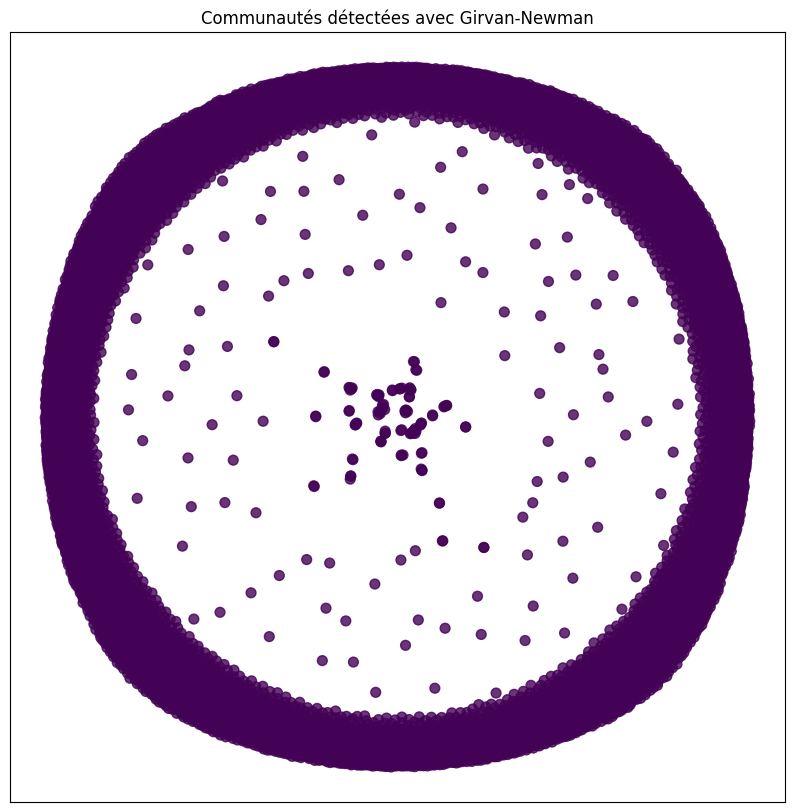

Nombre de communautés détectées : 2
Temps d'exécution : 606.6171 secondes


In [9]:

def limited_girvan_newman(G, max_levels=2):
    girvan_newman_generator = girvan_newman(G)
    top_level_communities = []


    for level in range(max_levels):
        try:
            communities = next(girvan_newman_generator)
            top_level_communities.append(communities)
        except StopIteration:
            break

    return top_level_communities


start_time = time.time()
top_level_communities = limited_girvan_newman(G_limited, max_levels=2)
end_time = time.time()

partition_gn = {}
for idx, community_level in enumerate(top_level_communities):
    for community in community_level:
        for node in community:
            partition_gn[node] = idx

def draw_girvan_newman_communities(graph, partition):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(graph)
    cmap = plt.get_cmap('viridis')
    colors = [cmap(partition[node]) for node in graph.nodes()]
    nx.draw_networkx_nodes(graph, pos, node_color=colors, node_size=50, alpha=0.8)
    nx.draw_networkx_edges(graph, pos, alpha=0.5)
    plt.title("Communautés détectées avec Girvan-Newman")
    plt.show()

draw_girvan_newman_communities(G_limited, partition_gn)


print(f"Nombre de communautés détectées : {len(top_level_communities)}")
print(f"Temps d'exécution : {end_time - start_time:.4f} secondes")

## Infomap Algorithm

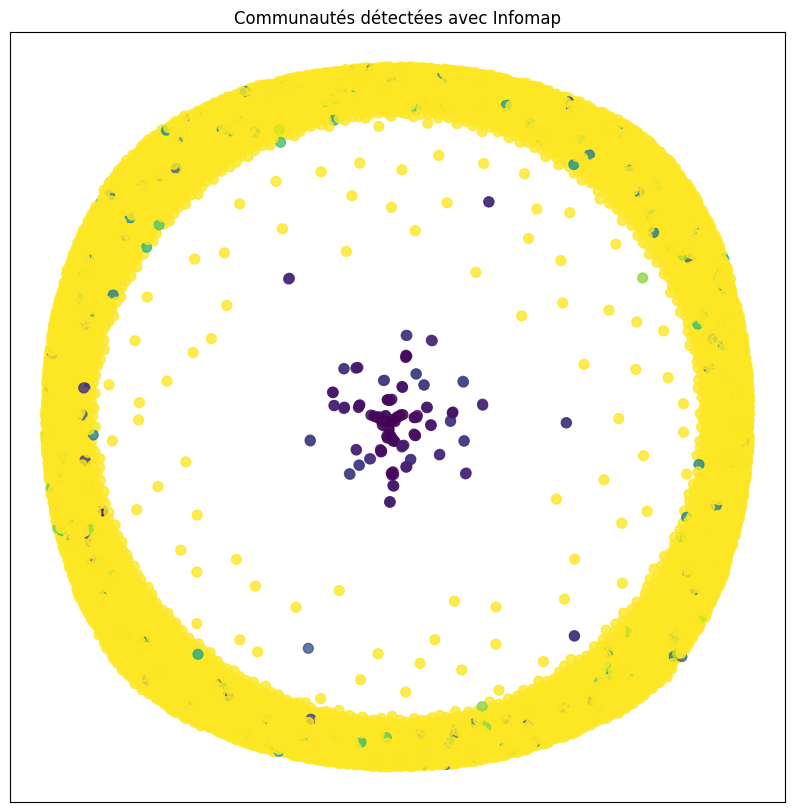

Nombre de communautés détectées par Infomap : 9902
Temps d'exécution : 0.2508 secondes


In [ ]:
from infomap import Infomap


im = Infomap()


node_mapping = {node: idx for idx, node in enumerate(G_limited.nodes)}
for node in G_limited.nodes:
    im.add_node(node_mapping[node])
for edge in G_limited.edges:
    im.add_link(node_mapping[edge[0]], node_mapping[edge[1]])

# Exécuter Infomap
start_time = time.time()
im.run()
end_time = time.time()

partition_infomap = {}
for node_id, module_id in im.modules:
    original_node = [node for node, mapped_id in node_mapping.items() if mapped_id == node_id][0]
    partition_infomap[original_node] = module_id

def draw_infomap_communities(graph, partition):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(graph)
    cmap = plt.get_cmap('viridis')
    colors = [cmap(partition[node]) for node in graph.nodes()]
    nx.draw_networkx_nodes(graph, pos, node_color=colors, node_size=50, alpha=0.8)
    nx.draw_networkx_edges(graph, pos, alpha=0.5)
    plt.title("Communautés détectées avec Infomap")
    plt.show()

draw_infomap_communities(G_limited, partition_infomap)


unique_communities = len(set(partition_infomap.values()))
print(f"Nombre de communautés détectées par Infomap : {unique_communities}")
print(f"Temps d'exécution : {end_time - start_time:.4f} secondes")

# Prédiction de Liens

## Common Neighbors

In [ ]:
def common_neighbors_prediction(G):
    print("\nPrédiction des liens avec Common Neighbors...")
    start_time = time.time()

    preds = ((u, v, len(list(nx.common_neighbors(G, u, v))))
             for u, v in nx.non_edges(G))

    sorted_preds = sorted(preds, key=lambda x: x[2], reverse=True)

    end_time = time.time()
    print(f"Temps d'exécution pour Common Neighbors : {end_time - start_time:.4f} secondes")

    print("Top 10 prédictions avec Common Neighbors :")
    for u, v, p in sorted_preds[:10]:
        print(f"Prédiction entre {u} et {v} : score={p}")

common_neighbors_prediction(G_limited)



Prédiction des liens avec Common Neighbors...
Temps d'exécution pour Common Neighbors : 847.7455 secondes
Top 10 prédictions avec Common Neighbors :
Prédiction entre 2833365481 et 1669389908 : score=1
Prédiction entre 2833365481 et 1120560888 : score=1
Prédiction entre 2833365481 et 1636297074 : score=1
Prédiction entre 4187726554 et 2911897047 : score=1
Prédiction entre 366739144 et 356299990 : score=1
Prédiction entre 142403541 et 3122044818 : score=1
Prédiction entre 66903190 et 256679742 : score=1
Prédiction entre 23022687 et 36399571 : score=1
Prédiction entre 4771114669 et 177005443 : score=1
Prédiction entre 2996279498 et 2618052793 : score=1


In [ ]:
non_existing_edges = list(nx.non_edges(G_limited))

In [ ]:
pos = nx.spring_layout(G_limited)

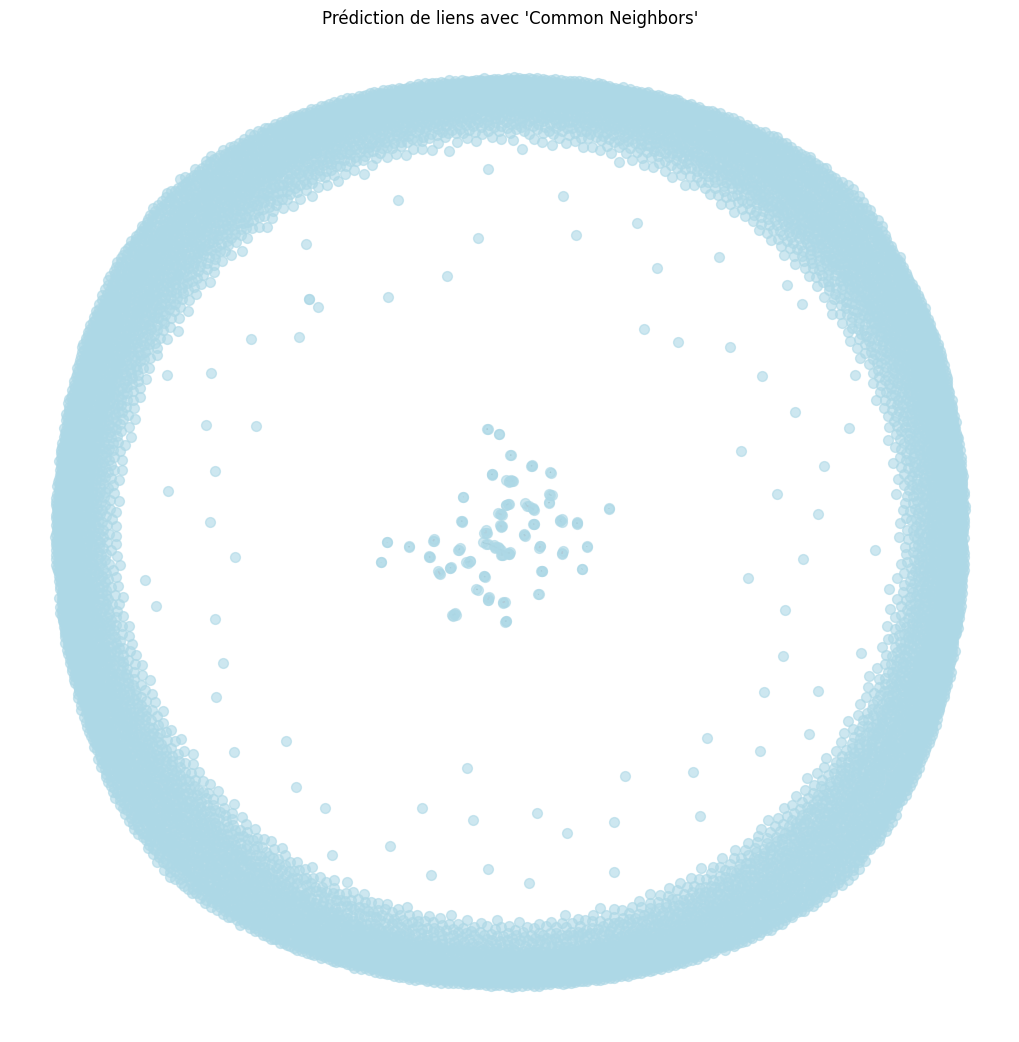

Temps d'exécution pour 'Common Neighbors': 1147.4390 secondes


In [ ]:
start_time = time.time()

non_existing_edges = list(nx.non_edges(G_limited))

cn_scores = [(u, v, len(list(nx.common_neighbors(G_limited, u, v)))) for u, v in non_existing_edges]

cn_scores = sorted(cn_scores, key=lambda x: x[2], reverse=True)

top_links = cn_scores[:20]
pos = nx.spring_layout(G_limited)
plt.figure(figsize=(10, 10))
nx.draw(G_limited, pos, node_color='lightblue', with_labels=False, node_size=50, alpha=0.6)
for u, v, score in top_links:
    nx.draw_networkx_edges(G_limited, pos, edgelist=[(u, v)], edge_color='r', alpha=0.8)
plt.title("Prédiction de liens avec 'Common Neighbors'")
plt.show()

end_time = time.time()
print(f"Temps d'exécution pour 'Common Neighbors': {end_time - start_time:.4f} secondes")


## Adamic-Adar

In [ ]:
def adamic_adar_prediction(G):
    print("\nPrédiction des liens avec l'index Adamic-Adar")
    start_time = time.time()

    preds = adamic_adar_index(G)

    sorted_preds = sorted(preds, key=lambda x: x[2], reverse=True)

    end_time = time.time()
    print(f"Temps d'exécution pour l'index Adamic-Adar : {end_time - start_time:.4f} secondes")

    print("Top 10 prédictions avec l'index Adamic-Adar :")
    for u, v, p in sorted_preds[:10]:
        print(f"Prédiction entre {u} et {v} : score={p:.4f}")

adamic_adar_prediction(G_limited)



Prédiction des liens avec l'index Adamic-Adar
Temps d'exécution pour l'index Adamic-Adar : 764.7980 secondes
Top 10 prédictions avec l'index Adamic-Adar :
Prédiction entre 743488498728984578 et 761960934411677696 : score=1.4427
Prédiction entre 2603304353 et 2534851266 : score=1.4427
Prédiction entre 64090343 et 326892184 : score=1.4427
Prédiction entre 29442313 et 1000949317 : score=1.4427
Prédiction entre 29442313 et 146185245 : score=1.4427
Prédiction entre 2594033532 et 2689027945 : score=1.4427
Prédiction entre 24254446 et 3024397797 : score=1.4427
Prédiction entre 531336358 et 1508429906 : score=1.4427
Prédiction entre 34643610 et 217064621 : score=1.4427
Prédiction entre 3110175078 et 3306286357 : score=1.4427


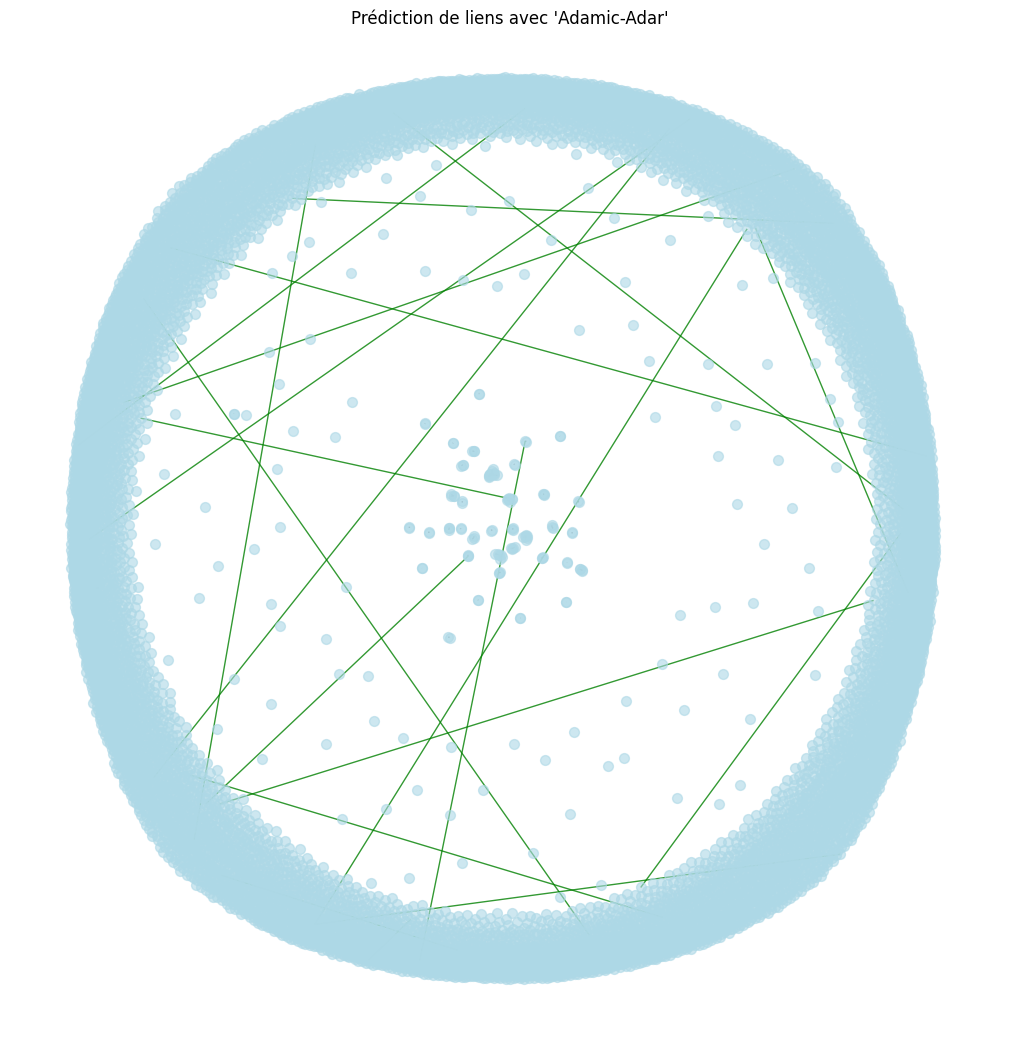

Temps d'exécution pour 'Adamic-Adar': 0.2313 secondes


In [ ]:

sampled_non_edges = random.sample(list(nx.non_edges(G_limited)), k=min(10000, len(list(nx.non_edges(G_limited)))))

start_time = time.time()
aa_scores = list(nx.adamic_adar_index(G_limited, sampled_non_edges))
aa_scores = sorted(aa_scores, key=lambda x: x[2], reverse=True)
end_time = time.time()

top_links_aa = aa_scores[:20]

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_limited)
nx.draw(G_limited, pos, node_color='lightblue', with_labels=False, node_size=50, alpha=0.6)
for u, v, score in top_links_aa:
    nx.draw_networkx_edges(G_limited, pos, edgelist=[(u, v)], edge_color='g', alpha=0.8)
plt.title("Prédiction de liens avec 'Adamic-Adar'")
plt.show()

print(f"Temps d'exécution pour 'Adamic-Adar': {end_time - start_time:.4f} secondes")


## Jaccard Coefficient

In [ ]:
def jaccard_coefficient_prediction(G):
    print("\nPrédiction des liens avec le Jaccard Coefficient...")
    start_time = time.time()

    preds = jaccard_coefficient(G)

    sorted_preds = sorted(preds, key=lambda x: x[2], reverse=True)

    end_time = time.time()
    print(f"Temps d'exécution pour le Jaccard Coefficient : {end_time - start_time:.4f} secondes")

    print("Top 10 prédictions avec le Jaccard Coefficient :")
    for u, v, p in sorted_preds[:10]:
        print(f"Prédiction entre {u} et {v} : score={p:.4f}")

jaccard_coefficient_prediction(G_limited)



Prédiction des liens avec le Jaccard Coefficient...
Temps d'exécution pour le Jaccard Coefficient : 660.8409 secondes
Top 10 prédictions avec le Jaccard Coefficient :
Prédiction entre 19773713 et 531980795 : score=1.0000
Prédiction entre 127363102 et 89001992 : score=1.0000
Prédiction entre 127363102 et 30719049 : score=1.0000
Prédiction entre 127363102 et 27821859 : score=1.0000
Prédiction entre 127363102 et 25212072 : score=1.0000
Prédiction entre 127363102 et 28224208 : score=1.0000
Prédiction entre 3142918574 et 1403195563 : score=1.0000
Prédiction entre 479090157 et 750462753240788994 : score=1.0000
Prédiction entre 479090157 et 285445263 : score=1.0000
Prédiction entre 844384501 et 3312638164 : score=1.0000


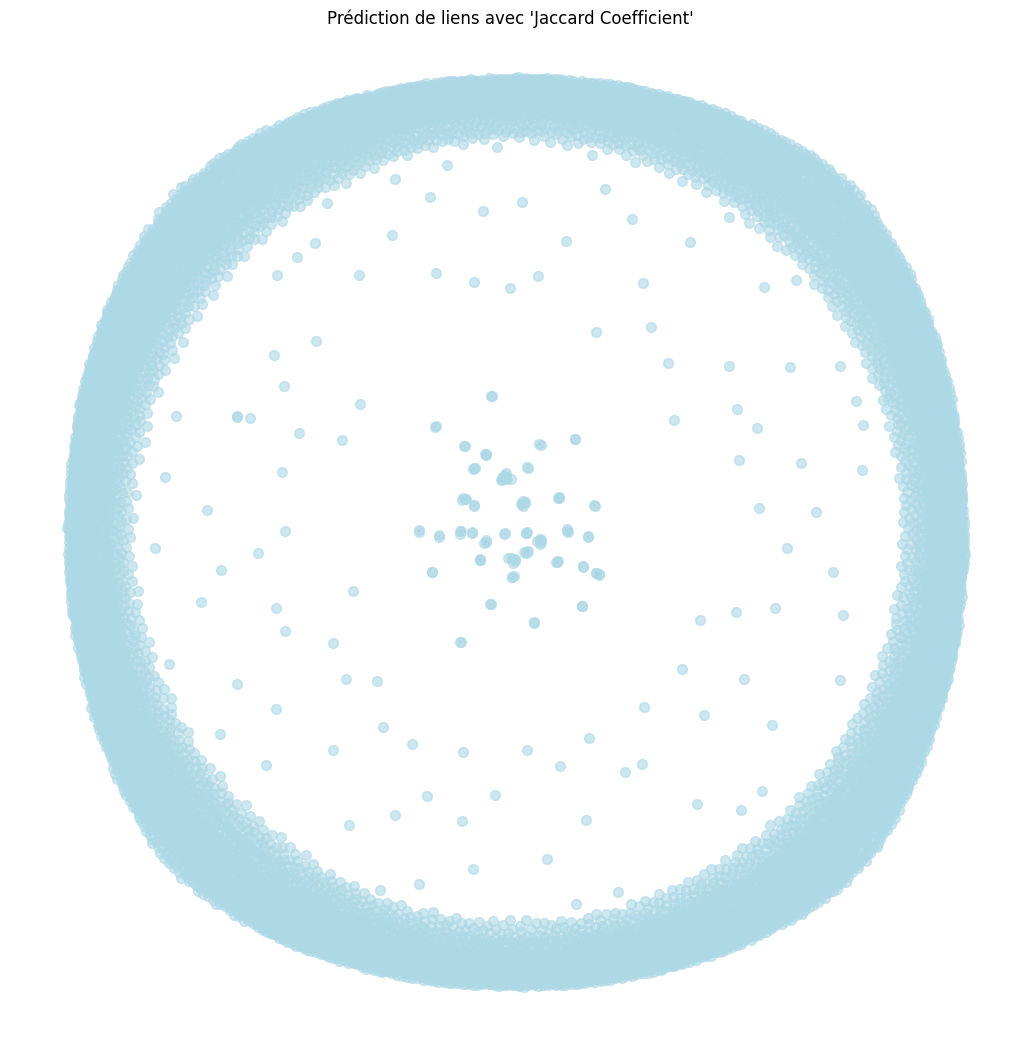

Temps d'exécution pour 'Jaccard Coefficient': 787.1092 secondes


In [ ]:
start_time = time.time()

jc_scores = list(nx.jaccard_coefficient(G_limited, non_existing_edges))

jc_scores = sorted(jc_scores, key=lambda x: x[2], reverse=True)

top_links_jc = jc_scores[:20]
plt.figure(figsize=(10, 10))
nx.draw(G_limited, pos, node_color='lightblue', with_labels=False, node_size=50, alpha=0.6)
for u, v, score in top_links_jc:
    nx.draw_networkx_edges(G_limited, pos, edgelist=[(u, v)], edge_color='b', alpha=0.8)
plt.title("Prédiction de liens avec 'Jaccard Coefficient'")
plt.show()

end_time = time.time()
print(f"Temps d'exécution pour 'Jaccard Coefficient': {end_time - start_time:.4f} secondes")


## Evaluation des Performances

In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc,roc_curve



def evaluate_predictions(predictions, G):
    y_true = []
    y_scores = []

    for u, v, score in predictions:
        y_true.append(1 if G.has_edge(u, v) else 0)
        y_scores.append(score)

    if len(set(y_true)) < 2:
        print("Attention : Une seule classe présente dans y_true. Impossible de calculer AUC-ROC ou AUC-PR.")
        return None, None, y_true, y_scores  # Retourne None pour AUC-ROC et AUC-PR

    auc_roc = roc_auc_score(y_true, y_scores)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    auc_pr = auc(recall, precision)

    return auc_roc, auc_pr, y_true, y_scores

In [ ]:
# 1. Méthode Common Neighbors
start_time = time.time()
non_existing_edges = list(nx.non_edges(G_limited))
cn_scores = [(u, v, len(list(nx.common_neighbors(G_limited, u, v)))) for u, v in non_existing_edges]
cn_scores_sorted = sorted(cn_scores, key=lambda x: x[2], reverse=True)
end_time = time.time()
print(f"Temps d'exécution pour 'Common Neighbors': {end_time - start_time:.4f} secondes")

auc_roc_cn, auc_pr_cn, y_true_cn, y_scores_cn = evaluate_predictions(cn_scores_sorted, G_limited)

if auc_roc_cn is None or auc_pr_cn is None:
    print("Impossible de calculer AUC-ROC ou AUC-PR pour 'Common Neighbors'.")
else:
    print(f"'Common Neighbors' AUC-ROC: {auc_roc_cn:.4f}, AUC-PR: {auc_pr_cn:.4f}")

    fpr_cn, tpr_cn, _ = roc_curve(y_true_cn, y_scores_cn)
    plt.figure()
    plt.plot(fpr_cn, tpr_cn, label=f"Common Neighbors (AUC = {auc_roc_cn:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Common Neighbors")
    plt.legend(loc="best")
    plt.show()

Temps d'exécution pour 'Common Neighbors': 778.9278 secondes
Attention : Une seule classe présente dans y_true. Impossible de calculer AUC-ROC ou AUC-PR.
Impossible de calculer AUC-ROC ou AUC-PR pour 'Common Neighbors'.


In [ ]:

start_time = time.time()
aa_scores = list(nx.adamic_adar_index(G_limited, non_existing_edges))
aa_scores_sorted = sorted(aa_scores, key=lambda x: x[2], reverse=True)
end_time = time.time()
print(f"Temps d'exécution pour 'Adamic-Adar': {end_time - start_time:.4f} secondes")

auc_roc_aa, auc_pr_aa, y_true_aa, y_scores_aa = evaluate_predictions(aa_scores_sorted, G_limited)

if auc_roc_aa is None or auc_pr_aa is None:
    print("Les métriques AUC-ROC ou AUC-PR pour 'Adamic-Adar' ne peuvent pas être calculées.")
else:
    print(f"'Adamic-Adar' AUC-ROC: {auc_roc_aa:.4f}, AUC-PR: {auc_pr_aa:.4f}")

    fpr_aa, tpr_aa, _ = roc_curve(y_true_aa, y_scores_aa)
    plt.figure()
    plt.plot(fpr_aa, tpr_aa, label=f"Adamic-Adar (AUC = {auc_roc_aa:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Adamic-Adar")
    plt.legend(loc="best")
    plt.show()

Temps d'exécution pour 'Adamic-Adar': 913.2731 secondes
Attention : Une seule classe présente dans y_true. Impossible de calculer AUC-ROC ou AUC-PR.
Les métriques AUC-ROC ou AUC-PR pour 'Adamic-Adar' ne peuvent pas être calculées.


In [ ]:
sample_size = 100000
non_existing_edges_sampled = random.sample(list(nx.non_edges(G_limited)), min(len(list(nx.non_edges(G_limited))), sample_size))

jc_scores = list(nx.jaccard_coefficient(G_limited, non_existing_edges_sampled))

jc_scores_filtered = [(u, v, score) for u, v, score in jc_scores if not (np.isnan(score) or np.isinf(score))]
top_k = 10000
jc_scores_sorted = sorted(jc_scores_filtered, key=lambda x: x[2], reverse=True)[:top_k]

auc_roc_jc, auc_pr_jc, y_true_jc, y_scores_jc = evaluate_predictions(jc_scores_sorted, G_limited)

if auc_roc_jc is None or auc_pr_jc is None:
    print("Les métriques AUC-ROC ou AUC-PR pour 'Jaccard Coefficient' ne peuvent pas être calculées.")
else:
    print(f"'Jaccard Coefficient' AUC-ROC: {auc_roc_jc:.4f}, AUC-PR: {auc_pr_jc:.4f}")
    fpr_jc, tpr_jc, _ = roc_curve(y_true_jc, y_scores_jc)
    plt.figure()
    plt.plot(fpr_jc, tpr_jc, label=f"Jaccard Coefficient (AUC = {auc_roc_jc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Jaccard Coefficient")
    plt.legend(loc="best")
    plt.show()

Attention : Une seule classe présente dans y_true. Impossible de calculer AUC-ROC ou AUC-PR.
Les métriques AUC-ROC ou AUC-PR pour 'Jaccard Coefficient' ne peuvent pas être calculées.
